In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.distributions import Normal
from torch.utils.data import Subset
from torch.distributions import Categorical, Normal, StudentT
from torch.optim import SGD
from torch.optim.lr_scheduler import PolynomialLR
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as tr
import torchmetrics
from torchmetrics.functional import calibration_error
import math
import matplotlib.pyplot as plt
import random
from collections import deque, OrderedDict
from tqdm import trange
import tqdm
import copy
import typing
from typing import Sequence, Optional, Callable, Tuple, Dict, Union
import pandas as pd

from data import Data
from Priors import *
from Networks import *
from BayesianNN import BNN_MCMC
from SGLD import SGLD

In [11]:
# Load MNIST dataset with specified transforms
# possible transforms: RandomRotation, RandomCrop, GaussianBlur
# avoid Normalize and ToTensor (already done), RandomHorizontalFlip (for MNIST), RandomVerticalFlip (for MNIST)
augmentations = tr.Compose([tr.RandomRotation(15)])

train_data, test_data = Data("MNIST", augmentations = None).get_data(num_train_samples=60000)

# Print some information about the dataset
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))


Train data size:  60000
Test data size:  10000


In [42]:
prior = Gaussian_Mixture(2, 0.5, -2, 0.5)
lol = BNN_MCMC(train_data, network = FullyConnectedNN(), prior=prior, num_epochs = 30, max_size = 15, burn_in = 5, lr = 1e-3, sample_interval = 2)
lol.train()

Training Model


100%|██████████| 30/30 [02:48<00:00,  5.63s/it, acc=0.117, log_prior_normalized=1.74e+6, loss=1.74e+6, lr=0.000183, nll_loss=1.14e+3] 


In [43]:
acc = lol.test_accuracy(test_data)
ece = lol.test_calibration(test_data)
print("Test accuracy: ", acc)
print("Test ECE: ", ece)

Test accuracy:  tensor(0.1169)
Test ECE:  tensor(0.0020)


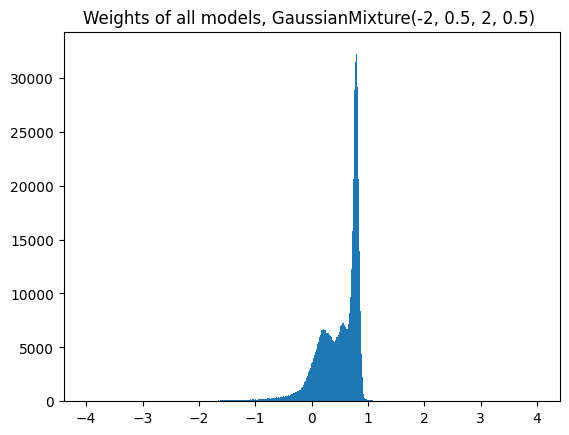

In [44]:
# get weights from all models
param_flat_all = []
for model in lol.model_sequence:
    parameters = model.state_dict()
    param_values = list(parameters.values())
    param_flat = torch.cat([v.flatten() for v in param_values])
    param_flat_all.append(param_flat.flatten())

# put all weights in one array
params = np.concatenate(param_flat_all)

# plot weights
plt.hist(params, bins=1000, range=(-4, 4))
plt.title("Weights of all models, GaussianMixture(-2, 0.5, 2, 0.5) ")
plt.show()

# Evaluation loop

In [ ]:
prior_list = [Isotropic_Gaussian(0, 1),
              StudentT_prior(),
              Laplace_prior(),
              Gaussian_Mixture(), 
              #GaussianSpikeNSlab(),
              MixedLaplaceUniform()]

sample_sizes = [3750, 7500, 15000, 30000, 60000, 120000]

Temperatures = [0.001, 0.01, 0.1, 1, 10]

In [ ]:
# preallocate pandas dataframe for results
results = pd.DataFrame(columns = ["Prior", "Sample Size", "Test Accuracy", "Test ECE"], index = range(len(prior_list)*len(sample_sizes)))

results

In [ ]:
# run the experiment for all priors

for n in range(len(sample_sizes)):
    # get data
    if sample_sizes[n] == 120000:
        # if sample size is 120000, use data augmentation
        augmentations = tr.Compose([tr.RandomRotation(15)])
        train_data, test_data = Data("MNIST", augmentations = augmentations).get_data()
    else:
        # subsample original train data if sample size is smaller than 120000
        train_data, test_data = Data("MNIST", augmentations = None).get_data(num_train_samples=sample_sizes[n])
    
    for i in range(len(prior_list)):
        # get prior
        prior = prior_list[i]
        print(50*"-")
        print(prior.name)

        # run BNN
        lol = BNN_MCMC(train_data, network = FullyConnectedNN(), prior=prior, num_epochs = 10, max_size = 10, burn_in = 2, lr = 1e-3, sample_interval = 1)
        lol.train()

        # get test accuracy and ECE
        acc = lol.test_accuracy(test_data)
        ece = lol.test_calibration(test_data)
        print("Test accuracy: ", acc)
        print("Test ECE: ", ece)

        # save results
        results.iloc[i+n*len(prior_list), :] = prior.name, sample_sizes[n], acc.numpy(), ece.numpy()
    

In [ ]:
# print full pandas dataframe
results